### Bike data set 
* Dataset (https://www.kaggle.com/competitions/bike-sharing-demand/data?select=train.csv)
* **Objective** Predict bike rentals based on hourly rental data. We are provided other weather data like temperature and windspeed.


In [193]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import numpy as np
import xlwings as xw

In [194]:
bike=pd.read_csv('Bike_Data/train.csv')

In [195]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### Exploratory Data Analysis
* First we convert the datetime column to a datetime datatype
* Next we check if any of the columns have null or missing values
* We then check the following relationships.
    * Relationship between month of year and count of rentals
    * Relationship between temperature and count of Rentals 

In [196]:
bike.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [197]:
bike['datetime']=pd.to_datetime(bike.datetime)

In [198]:
bike.season.value_counts()

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64

In [199]:
bike['MonthofYear']=bike.datetime.dt.month

In [200]:
bike.drop(columns=['registered','casual'],inplace=True)

In [201]:
book=xw.Book('Bike_Data/Report_Dashboard.xlsx')

In [202]:
sheet=book.sheets('Exploratory Analysis')

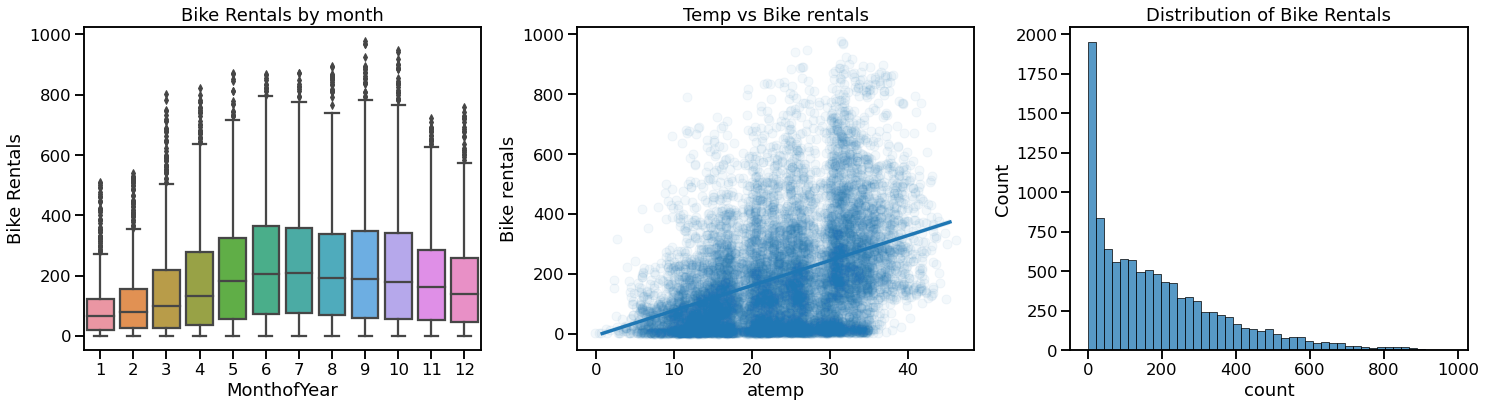

<Picture 'Bike Rentals' in <Sheet [Report_dashboard.xlsx]Exploratory Analysis>>

In [203]:
fig,(ax0,ax1,ax2)=plt.subplots(nrows=1,ncols=3)
fig.set_figheight(6)
fig.set_figwidth(21)
sns.boxplot(x='MonthofYear',y='count',data=bike,ax=ax0)
sns.regplot(x='atemp',y='count',scatter=True,scatter_kws={'alpha':0.05},x_jitter=True,y_jitter=True,data=bike,ax=ax1)
sns.histplot(x='count',data=bike,ax=ax2)
ax0.set_title('Bike Rentals by month')
ax0.set_ylabel('Bike Rentals')
ax1.set_title('Temp vs Bike rentals')
ax1.set_ylabel('Bike rentals')
ax2.set_label('Bike Rentals')
ax2.set_title('Distribution of Bike Rentals')
plt.tight_layout()
sns.set_context('talk')
#sns.set_theme('dark')
plt.show()
sheet.pictures.add(fig,name='Bike Rentals',update=True)

In [204]:
corr_mat=bike.corr().round(2)
corr_mat

season  holiday  workingday  weather  temp  atemp  humidity  \
season         1.00     0.03       -0.01     0.01  0.26   0.26      0.19   
holiday        0.03     1.00       -0.25    -0.01  0.00  -0.01      0.00   
workingday    -0.01    -0.25        1.00     0.03  0.03   0.02     -0.01   
weather        0.01    -0.01        0.03     1.00 -0.06  -0.06      0.41   
temp           0.26     0.00        0.03    -0.06  1.00   0.98     -0.06   
atemp          0.26    -0.01        0.02    -0.06  0.98   1.00     -0.04   
humidity       0.19     0.00       -0.01     0.41 -0.06  -0.04      1.00   
windspeed     -0.15     0.01        0.01     0.01 -0.02  -0.06     -0.32   
count          0.16    -0.01        0.01    -0.13  0.39   0.39     -0.32   
MonthofYear    0.97     0.00       -0.00     0.01  0.26   0.26      0.20   

             windspeed  count  MonthofYear  
season           -0.15   0.16         0.97  
holiday           0.01  -0.01         0.00  
workingday        0.01   0.01        -0.00  
weather           0.01  -0.13         0.01  
temp             -0.02   0.39         0.26  
atemp            -0.06   0.39         0.26  
humidity         -0.32  -0.32         0.20  
windspeed         1.00   0.10        -0.15  
count             0.10   1.00         0.17  
MonthofYear      -0.15   0.17         1.00

In [205]:
fig,ax=plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(14)
sns.heatmap(corr_mat,annot=True,linewidth=0.3,cmap='viridis')
ax.set_title('Correlation Matrix')
sheet.pictures.add(fig,name='Corr_mat',update=True,left=sheet.range('B37').left,top=sheet.range('B37').top)

<Picture 'Corr_mat' in <Sheet [Report_dashboard.xlsx]Exploratory Analysis>>

In [206]:
X=bike[['atemp','MonthofYear','humidity','weather','holiday']]
y=bike['count']

In [207]:
bike.holiday.value_counts()

0    10575
1      311
Name: holiday, dtype: int64

In [208]:
y

0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: count, Length: 10886, dtype: int64

In [209]:
from sklearn.model_selection import train_test_split

In [210]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [211]:
max_depths=[3,4,5,6,7,8,9,10,11,12,13,14,15]
for max_depth in max_depths:
    dt=DecisionTreeRegressor(max_depth=max_depth,random_state=20)
    dt.fit(X_train,y_train)
    y_pred=dt.predict(X_test)
    score=r2_score(y_test,y_pred)
    print('The r2_score of tree with max depth {} is'.format(max_depth),score)

The r2_score of tree with max depth 3 is 0.236416219265717
The r2_score of tree with max depth 4 is 0.26081269388723105
The r2_score of tree with max depth 5 is 0.27097077121803737
The r2_score of tree with max depth 6 is 0.295213151067129
The r2_score of tree with max depth 7 is 0.3007761496952043
The r2_score of tree with max depth 8 is 0.31655053490527973
The r2_score of tree with max depth 9 is 0.31091609353242056
The r2_score of tree with max depth 10 is 0.3120784375047242
The r2_score of tree with max depth 11 is 0.27410696732602235
The r2_score of tree with max depth 12 is 0.24911034218534978
The r2_score of tree with max depth 13 is 0.2359421352627893
The r2_score of tree with max depth 14 is 0.20957996533012657
The r2_score of tree with max depth 15 is 0.17968590127232764


In [212]:
dt=DecisionTreeRegressor(max_depth=4)

In [213]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=4)

In [214]:
y_pred=dt.predict(X_test)

In [215]:
sheet2=book.sheets('Decision tree')

In [216]:
from sklearn import tree
fig,ax=plt.subplots()
fig.set_figheight(35)
fig.set_figwidth(35)
_=tree.plot_tree(dt,feature_names=X.columns,filled=True)

sheet2.pictures.add(fig,name='Tree',update=True,left=sheet2.range('A6').left,top=sheet2.range('A6').left)

<Picture 'Tree' in <Sheet [Report_dashboard.xlsx]Decision Tree>>

In [217]:
type(fig)

matplotlib.figure.Figure

In [218]:
dt=DecisionTreeRegressor(max_depth=7)

In [219]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=7)

In [220]:
y_pred=dt.predict(X_test)

In [221]:
sheet2.range('B2').value=dt.max_depth
sheet2.range('B3').value=r2_score(y_test,y_pred).round(2)

### Now trying Random forest
* We will probably not know the number of registered users ahead of time so drop the columns casual and registered to make this problem interestins
* We can use random forest to get feature importances and use it as a dimensionality reduction technique

In [222]:
#bike.drop(columns=['registered','casual'],inplace=True)

In [223]:
X=bike.drop(columns=['count','datetime'])

In [224]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       10886 non-null  int64  
 1   holiday      10886 non-null  int64  
 2   workingday   10886 non-null  int64  
 3   weather      10886 non-null  int64  
 4   temp         10886 non-null  float64
 5   atemp        10886 non-null  float64
 6   humidity     10886 non-null  int64  
 7   windspeed    10886 non-null  float64
 8   MonthofYear  10886 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 765.5 KB


In [225]:
y=bike['count']

In [226]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [227]:
X_train

season  holiday  workingday  weather   temp   atemp  humidity  \
974         1        0           0        2  12.30  15.910        81   
9703        4        1           0        3  17.22  21.210        58   
10238       4        1           0        1  17.22  21.210        71   
2348        2        0           0        1  28.70  32.575        58   
2932        3        0           1        1  28.70  32.575        61   
...       ...      ...         ...      ...    ...     ...       ...   
10780       4        0           0        1  16.40  20.455        50   
9294        3        0           1        1  27.06  31.060        31   
5591        1        0           0        1  14.76  16.665        37   
2137        2        0           0        1  22.14  25.760        88   
2865        3        0           1        2  28.70  33.335        79   

       windspeed  MonthofYear  
974       7.0015            3  
9703     12.9980           10  
10238     7.0015           11  
2348      7.0015            6  
2932     15.0013            7  
...          ...          ...  
10780    11.0014           12  
9294     26.0027            9  
5591     19.0012            1  
2137     15.0013            5  
2865     12.9980            7  

[8708 rows x 9 columns]

In [228]:
from sklearn.ensemble import RandomForestRegressor

In [229]:
for max_depth in max_depths:
    rf=RandomForestRegressor(n_estimators=100,max_depth=max_depth,random_state=30)
    rf.fit(X_train,y_train)
    y_pred=rf.predict(X_test)
    score=r2_score(y_test,y_pred)
    print('R2_score with {} max depth is'.format(max_depth),score)

R2_score with 3 max depth is 0.25525027063821926
R2_score with 4 max depth is 0.2991692992985452
R2_score with 5 max depth is 0.32516068328889125
R2_score with 6 max depth is 0.34666766764839674
R2_score with 7 max depth is 0.360448171932647
R2_score with 8 max depth is 0.37266128767336937
R2_score with 9 max depth is 0.38119602679287035
R2_score with 10 max depth is 0.3847079318868073
R2_score with 11 max depth is 0.38523076940954404
R2_score with 12 max depth is 0.3821825161474436
R2_score with 13 max depth is 0.3776077863864077
R2_score with 14 max depth is 0.3711316154718879
R2_score with 15 max depth is 0.3620356081227569


In [231]:
rf=RandomForestRegressor(n_estimators=100,max_depth=11,random_state=30)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
score=r2_score(y_test,y_pred)
sheet3=book.sheets('Random forest')
sheet3.range('B4').value=score.round(2)
sheet3.range('B2').value=rf.n_estimators
sheet3.range('B3').value=rf.max_depth

In [232]:
mat=pd.DataFrame(rf.feature_importances_,index=X.columns).sort_values(by=[0])
fig,ax=plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(12)
ax.barh(width=mat[0],y=mat.index)
plt.xticks(rotation=45)
ax.set_title('Feature Importances')
sheet3.pictures.add(fig,name='Feature',update=True,left=sheet3.range('A8').left,top=sheet3.range('A8').left)

<Picture 'Feature' in <Sheet [Report_dashboard.xlsx]Random Forest>>

In [123]:
type(mat)

matplotlib.axes._subplots.AxesSubplot